In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [49]:
L63_data_path = '../data/L63-trajectories'
save_folder = '../data/nn_1'
N = 20000
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float32)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(np.float32)

model = srnn.SurrogateModel_NN(3, 300, name='nn_0', save_folder=save_folder)
model.compute_train_error(train, 200, 800)

Time taken by compute_train_error is 1.3997 seconds


In [36]:
iters = list(range(20000, 1000000, 10000))
df = pd.read_csv(model.save_folder + '/train_log.csv')
tau = np.zeros(len(iters))
loss = np.zeros_like(tau)
train_error = np.zeros_like(tau)
for i, iter in enumerate(iters):
    model.load(iter)
    tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
    tau[i] = tau_f_se.mean()
    train_error[i] = df[df['iteration']==iter]['train_sq_err'].to_numpy()[0]
    loss[i] = df[df['iteration']==iter]['loss'].to_numpy()[0]
    print(i)

Time taken by compute_tau_f is 1.3238 seconds
0
Time taken by compute_tau_f is 1.3038 seconds
1
Time taken by compute_tau_f is 1.3096 seconds
2
Time taken by compute_tau_f is 1.3103 seconds
3
Time taken by compute_tau_f is 1.3133 seconds
4
Time taken by compute_tau_f is 1.3559 seconds
5
Time taken by compute_tau_f is 1.3253 seconds
6
Time taken by compute_tau_f is 1.3175 seconds
7
Time taken by compute_tau_f is 1.3145 seconds
8
Time taken by compute_tau_f is 1.3279 seconds
9
Time taken by compute_tau_f is 1.3617 seconds
10
Time taken by compute_tau_f is 1.3241 seconds
11
Time taken by compute_tau_f is 1.3167 seconds
12
Time taken by compute_tau_f is 1.3188 seconds
13
Time taken by compute_tau_f is 1.3221 seconds
14
Time taken by compute_tau_f is 1.3306 seconds
15
Time taken by compute_tau_f is 1.3245 seconds
16
Time taken by compute_tau_f is 1.3575 seconds
17
Time taken by compute_tau_f is 1.3256 seconds
18
Time taken by compute_tau_f is 1.3185 seconds
19
Time taken by compute_tau_f is

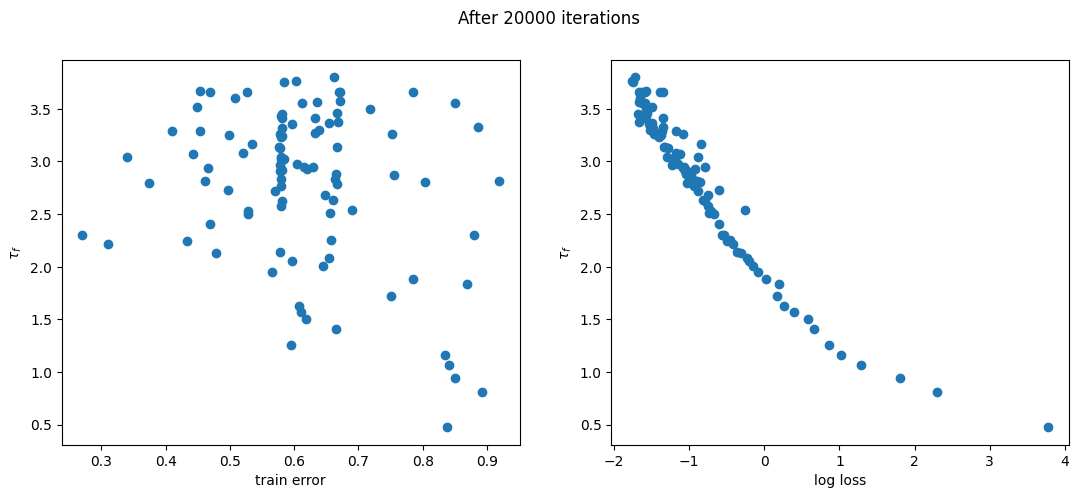

In [46]:
df = pd.read_csv(model.save_folder + '/train_log.csv')

fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.scatter(train_error, tau)
ax2.scatter(np.log(loss), tau)

ax1.set_xlabel('train error')
ax1.set_ylabel(r'$\tau_f$')
ax2.set_xlabel('log loss')
ax2.set_ylabel(r'${\tau_f}$')
fig.suptitle('After 20000 iterations')
plt.savefig(f'{model.save_folder}/tau_f_vs_train_error_loss.png')

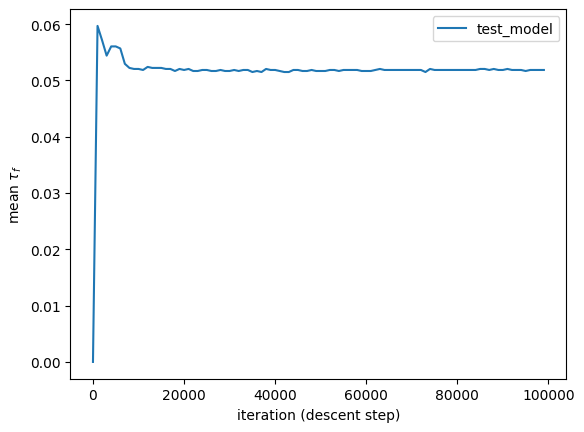

In [4]:
plt.plot(iters, tau, label="test_model")
plt.xlabel('iteration (descent step)')
plt.ylabel(r'mean $\tau_f$')
plt.legend()
plt.savefig('../data/nn_70_2/iter_vs_mean_tau_f.png')

In [4]:
model.get_save_idx()[-1]

199900

In [6]:
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(train.T.reshape(-1, 3, 800))

plt.hist(tau_f_se)
plt.xlabel(r'$\tau_f$ (NN), for train data')
plt.title(f'training_data_size={N}')

ValueError: cannot reshape array of size 60 into shape (3,800)

In [10]:
for k, v in model.net.state_dict().items():
    print(k)

0.weight
0.bias
2.weight


In [ ]:
for batch, (X, y) in enumerate(train_dataloader):
    print(X, y)

In [ ]:
fig, N, dt = plt.figure(figsize=(8, 8)), 500, 0.02
t = np.arange(0., N*dt, dt) / (1/0.91)
axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
dims = ['x', 'y', 'z']
u = np.load('{}/validation.npy'.format(L63_data_path)).astype(np.float32)
u = train
idx = [[4, 14, 18], [13, 17, 46], [13, 2, 31], ]
labels = ['good', 'medium', 'bad']
predicted = model.multistep_forecast(u[:, 0], N)
for i, ax in enumerate(axs):
    ax.plot(t, u[i, :N], label='truth')
    ax.plot(t, predicted[i, :N], label='network')
    ax.legend(loc='upper right')
    if i == len(dims)-1:
        ax.set_xlabel('t')
    ax.set_ylabel(dims[i])

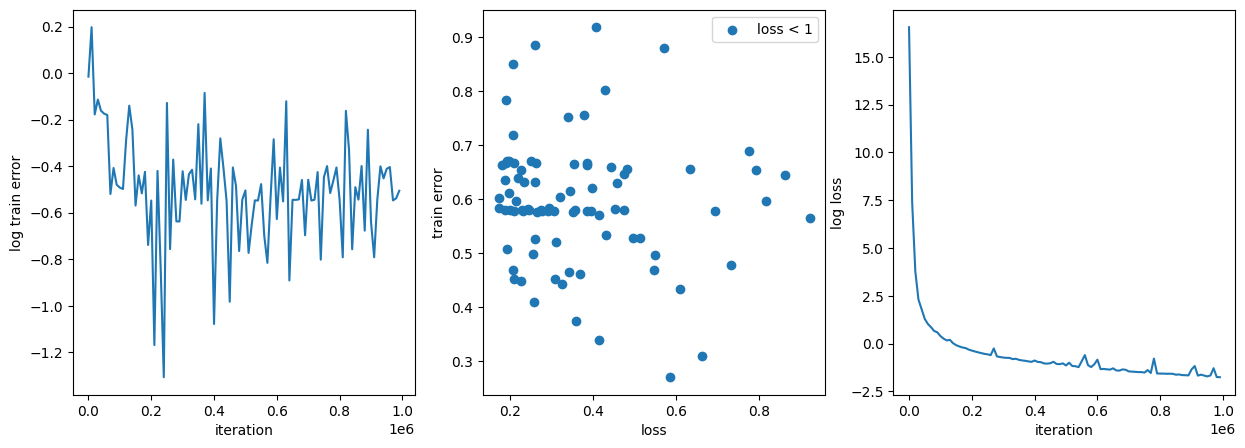

In [20]:
df = pd.read_csv(model.save_folder + '/train_log.csv')

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(df['iteration'][::100], np.log(df['train_sq_err'][::100]))
ax3.plot(df['iteration'][::100], np.log(df['loss'][::100]))
df = df[df['loss']< 1]
ax2.scatter((df['loss']), (df['train_sq_err']), label='loss < 1')

ax1.set_xlabel('iteration')
ax1.set_ylabel('log train error')
ax3.set_xlabel('iteration')
ax3.set_ylabel('log loss')

ax2.set_xlabel('loss')
ax2.set_ylabel('train error')
ax2.legend()
plt.savefig(f'{model.save_folder}/train_error_vs_loss.png')

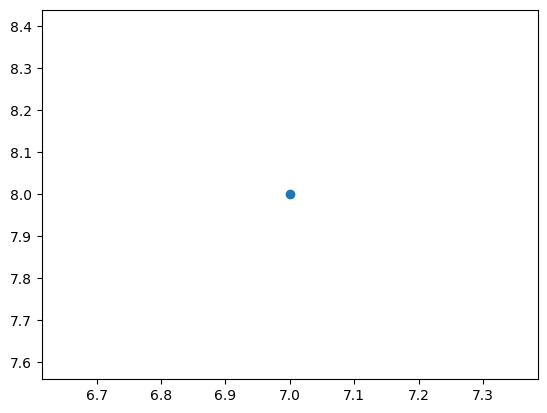

In [7]:
plt.scatter([np.nan, 7], [9, 8])

In [44]:
train_error.min()

0.2705492130505271

In [52]:
optim = torch.optim.Adam(model.net.parameters(), lr=1e-3)

In [55]:
for g in optim.param_groups:
    print(g['lr'])

0.0001


In [54]:
optim.param_groups[0]['lr']=1e-4

In [56]:
a = [1, 3. , 6]

In [57]:
a.pop(0)

1

In [58]:
a

[3.0, 6]